In [2]:
import pandas as pd
from pandas import HDFStore, DataFrame
import os
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import re
import random
import sklearn
from sklearn.model_selection import train_test_split
import glob
import geopy.distance
from math import radians, cos, sin, asin, sqrt

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
import typhon
from typhon.retrieval.qrnn import QRNN
from math import radians, cos, sin, asin, sqrt

import itertools
import matplotlib.gridspec as gridspec
from matplotlib.ticker import LogFormatter
from matplotlib.colors import LogNorm

In [3]:
def closest_quantile_to_threshold(preds, threshold, quantiles):
    closest_quantile = 0
    for i in range(0,len(preds)):
        tmp_pred = preds[i]
        if tmp_pred < threshold and closest_quantile < len(quantiles) - 1:
            closest_quantile = closest_quantile + 1
    return closest_quantile

def get_qrnn_PoP(qrnn_preds, threshold, quantiles):
    PoP = 100 * (1 - quantiles[closest_quantile_to_threshold(qrnn_preds, threshold, quantiles)])
    return PoP

In [4]:
# Load networks
qrnn_name = "qrnn_14_128_extra_extra_data"
qrnn = QRNN.load(qrnn_name)

In [5]:
input_path   = '/home/teodor/Documents/QRNN_GPM_project/database_testing/qrnn_input'
gprof_path   = '/home/teodor/Documents/QRNN_GPM_project/database_testing/gprof_retrievals'
gt_path      = '/home/teodor/Documents/QRNN_GPM_project/database_testing/ground_truth'
qrnn_files   = np.sort(glob.glob(input_path + '/*.txt'))
gprof_files  = np.sort(glob.glob(gprof_path + '/*.txt'))
gt_files     = np.sort(glob.glob(gt_path + '/*.txt'))

In [6]:
file_nbr = 80
qrnn_input    = np.loadtxt(qrnn_files[file_nbr])
GPROF_output  = np.loadtxt(gprof_files[file_nbr])
ground_truth  = np.loadtxt(gt_files[file_nbr])

# REMOVE ANY STRANGE INPUTS
for i in range(0,13):
    tmp = qrnn_input[:,i]
    del_inds = np.where(tmp > 600)
    qrnn_input = np.delete(qrnn_input, (del_inds), axis = 0)
    GPROF_output = np.delete(GPROF_output, (del_inds), axis = 0)
    ground_truth = np.delete(ground_truth, (del_inds), axis = 0)

for i in range(0,15):
    tmp = qrnn_input[:,i]
    del_inds = np.where(tmp < 0)
    qrnn_input = np.delete(qrnn_input, (del_inds), axis = 0)
    GPROF_output = np.delete(GPROF_output, (del_inds), axis = 0)
    ground_truth = np.delete(ground_truth, (del_inds), axis = 0)
print(qrnn_input.shape)

# Prepare different input vectors for predicting
labels = ground_truth[:,0]
longitudes = ground_truth[:,1]
latitudes = ground_truth[:,2]
x_test = qrnn_input
GPROF_033 = GPROF_output[:,2]
GPROF_066 = GPROF_output[:,3]
GPROF_data = GPROF_output[:,0]
GPROF_PoP = GPROF_output[:,4]
print(np.max(labels))
print(qrnn_files[file_nbr])

(39710, 15)
41.04951477050781
/home/teodor/Documents/QRNN_GPM_project/database_testing/qrnn_input/QRNN_inputs_1502_6.txt


In [7]:
# MAKE QRNN RETRIEVALS
quantile_nbr = 5
qrnn_preds = qrnn.predict(x_test)
qrnn_05 = np.copy(qrnn_preds[:,quantile_nbr])

41.04951477050781


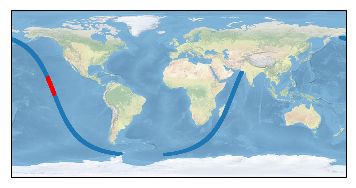

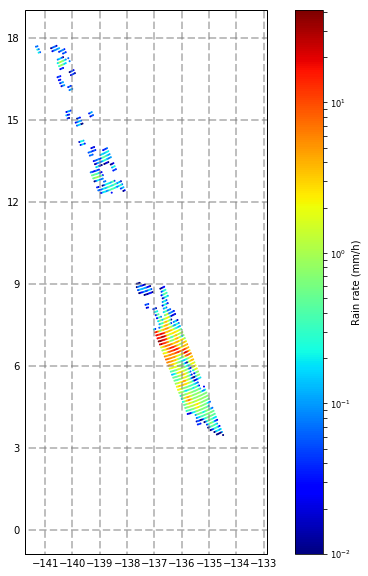

In [8]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

a = 24000# DPR start index
b = 27000# DPR end index

lons = longitudes[a:b]
lats = latitudes[a:b]
gt_data = labels[a:b]

min_val = 0.01
max_val = np.max(gt_data)
print(max_val)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

plt.scatter(longitudes,latitudes, s = 1)
plt.scatter(lons,lats,s=1,c='red')

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.scatter(lons,lats,marker='o',s=1,c=gt_data,cmap='jet',
            norm = LogNorm(vmin=min_val, vmax = max_val))
cbar = plt.colorbar()
cbar.set_label("Rain rate (mm/h)", labelpad=+1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True


plt.show()

GT                 GPROF             QRNN 0.9  sec terital      QRNN 0.5
[41.04951477050781, 38.212188720703125, 51.583694, 20.0, 36.46123]
51.58369445800781


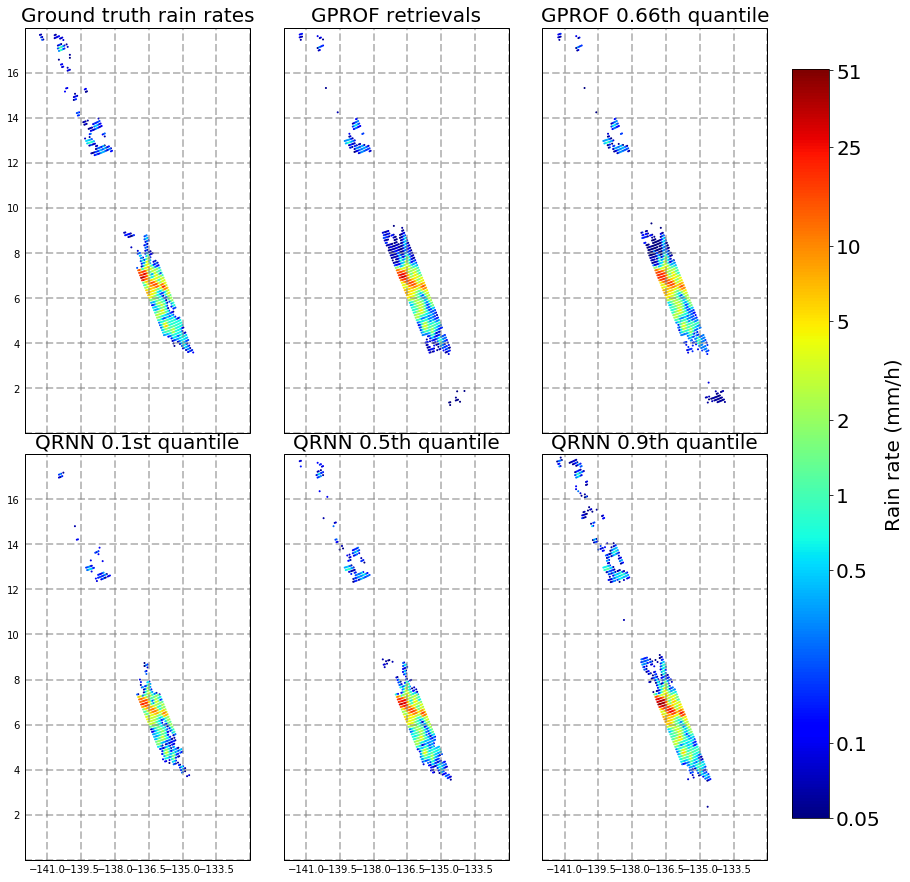

In [9]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=proj),figsize = (20,20))
ax1 = axes.flatten()[0]
ax2 = axes.flatten()[1]
ax3 = axes.flatten()[2]
ax4 = axes.flatten()[3]
ax5 = axes.flatten()[4]
ax6 = axes.flatten()[5]

ymin = 0
ymax = 18
xmin = -142
xmax = -132

threshold = 0.05
DPR_marker = 1
GMI_marker = DPR_marker
color_map = 'jet'
cbar_font = 18
cbar_tick = 15
title_font = 20
frac = 0.043
DPR_edge_col = 'black'
DPR_edge_width = 2
tick_size = 20

qrnn_data_05 = qrnn_05[a:b]
qrnn_data_09 = qrnn_preds[a:b,-2]
qrnn_data_01 = qrnn_preds[a:b,1]
gprof_data   = GPROF_data[a:b]
sec_tertial  = GPROF_066[a:b]


max_vals = [np.max(gt_data), np.max(gprof_data), np.max(qrnn_data_09), np.max(sec_tertial), np.max(qrnn_data_05)]
max_val = np.max(max_vals)
min_val = threshold

print('GT                 GPROF             QRNN 0.9  sec terital      QRNN 0.5')
print(max_vals)
print(max_val)

# PLOT GROUND TRUTH VALUES
rain_ins = np.where(gt_data > threshold)
ax1.coastlines()
plt1 = ax1.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=gt_data[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax1.set_xlim([xmin,xmax])
ax1.set_ylim([ymin,ymax])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax1.set_title('Ground truth rain rates', fontsize = title_font)

# PLOT GPROF RETRIEVALS
rain_ins = np.where(gprof_data > threshold)
ax2.coastlines()
plt2 = ax2.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=gprof_data[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax2.set_xlim([xmin,xmax])
ax2.set_ylim([ymin,ymax])
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax2.set_title('GPROF retrievals', fontsize = title_font)

# PLOT GPROF SECOND TERTIAL
rain_ins = np.where(sec_tertial > threshold)
ax3.coastlines()
plt3 = ax3.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=sec_tertial[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax3.set_xlim([xmin,xmax])
ax3.set_ylim([ymin,ymax])
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax3.set_title('GPROF 0.66th quantile', fontsize = title_font)

# PLOT QRNN 0.1ST QUANTILE
rain_ins = np.where(qrnn_data_01 > threshold)
ax4.coastlines()
plt4 = ax4.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=qrnn_data_01[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax4.set_xlim([xmin,xmax])
ax4.set_ylim([ymin,ymax])
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax4.set_title('QRNN 0.1st quantile', fontsize = title_font)

# PLOT QRNN MEDIAN
rain_ins = np.where(qrnn_data_05 > threshold)
ax5.coastlines()
plt5 = ax5.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=qrnn_data_05[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax5.set_xlim([xmin,xmax])
ax5.set_ylim([ymin,ymax])
gl = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax5.set_title('QRNN 0.5th quantile', fontsize = title_font)

# PLOT QRNN 0.9TH QUANTILE
rain_ins = np.where(qrnn_data_09 > threshold)
ax6.coastlines()
plt6 = ax6.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=qrnn_data_09[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax6.set_xlim([xmin,xmax])
ax6.set_ylim([ymin,ymax])
gl = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax6.set_title('QRNN 0.9th quantile', fontsize = title_font)


#fig.text(0.095, 0.82, 'Latitude', va='center', rotation='vertical',fontsize = title_font+2)
#fig.text(0.42, 0.66, 'Longitude', ha='center',fontsize = title_font+2)

fig.tight_layout()
fig.subplots_adjust(bottom = 0.4, left = 0.13, right = 0.8)

formatter = LogFormatter(10, labelOnlyBase=False)
cbar = fig.colorbar(plt1, ax=axes.ravel().tolist(), shrink = 0.9, pad = 0.025,
                   ticks = [min_val,0.1,0.5,1,2,5,10,25,int(max_val)])
cbar.ax.set_yticklabels([str(min_val),'0.1' ,'0.5','1','2','5','10','25',str(int(max_val))])

cbar.set_label("Rain rate (mm/h)", fontsize = 20)
cbar.ax.tick_params(labelsize=20)



plt.show()

In [21]:
#Sample posterior
print(x_test.shape)
n_samples = 1000
qrnn_samples = np.zeros((qrnn_preds.shape[0],n_samples))
for i in range(0,len(x_test)):
    if np.mod(i,10000) == 0:
        print(int(100*i/len(x_test)))
    qrnn_samples[i,:] = qrnn.sample_posterior(x_test[i],n_samples)

qrnn_mean = np.mean(qrnn_samples, axis = 1)
print(np.max(qrnn_samples))

(39710, 15)
0
25
50
75
77.25363884121202


In [45]:
qrnn_mean_var = np.std(qrnn_samples, axis=1)

Median      Ground truth     sample 1  sample 2      sample 3     qrnn mean
[36.46123, 41.04951477050781, 15.47831, 23.49075, 27.58487, 36.14126672540102]
41.04951477050781


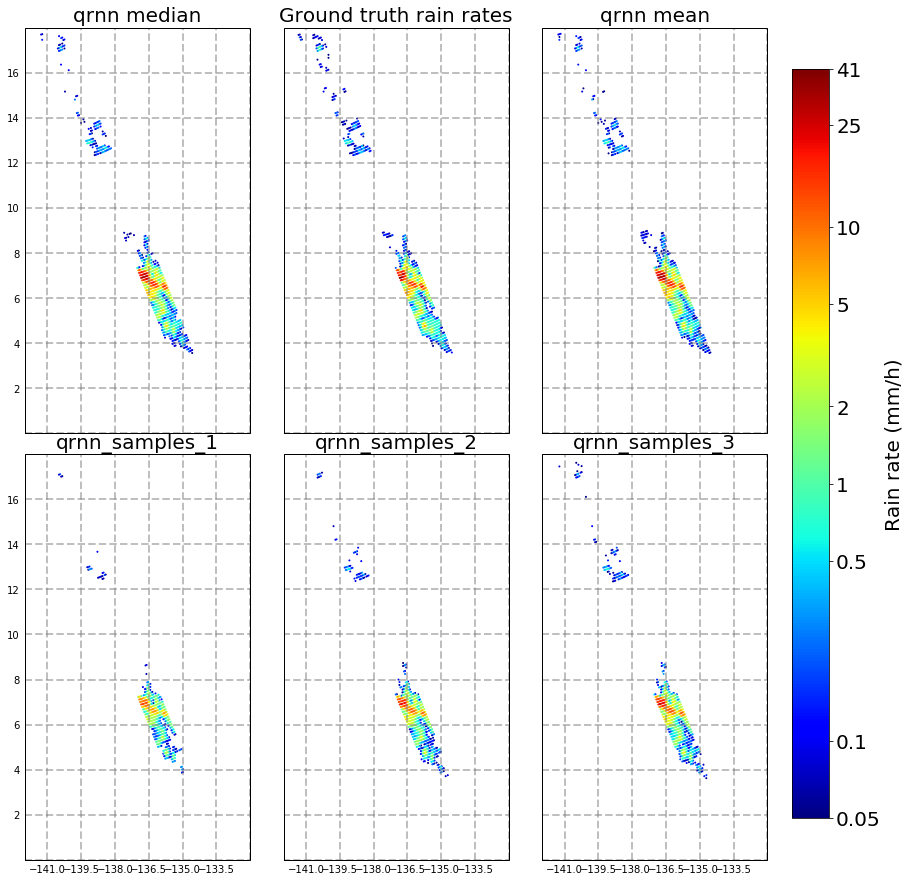

In [11]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=proj),figsize = (20,20))
ax1 = axes.flatten()[0]
ax2 = axes.flatten()[1]
ax3 = axes.flatten()[2]
ax4 = axes.flatten()[3]
ax5 = axes.flatten()[4]
ax6 = axes.flatten()[5]

GMI_marker = DPR_marker
color_map = 'jet'
cbar_font = 18
cbar_tick = 15
title_font = 20
frac = 0.043
DPR_edge_col = 'black'
DPR_edge_width = 2
tick_size = 20

qrnn_data_05 = qrnn_05[a:b]
qrnn_samples_1 = qrnn_preds[a:b,0]
qrnn_samples_2 = qrnn_preds[a:b,1]
qrnn_samples_3 = qrnn_preds[a:b,2]
qrnn_samples_4 = qrnn_preds[a:b,3]
qrnn_samples_5 = qrnn_preds[a:b,4]
qrnn_mean_tmp  = qrnn_mean[a:b]



max_vals = [np.max(qrnn_data_05), np.max(gt_data), np.max(qrnn_samples_1),
            np.max(qrnn_samples_2), np.max(qrnn_samples_3), np.max(qrnn_mean_tmp)]
max_val = np.max(max_vals)
min_val = threshold

print('Median      Ground truth     sample 1  sample 2      sample 3     qrnn mean')
print(max_vals)
print(max_val)

# PLOT GROUND TRUTH VALUES
rain_ins = np.where(qrnn_data_05 > threshold)
ax1.coastlines()
plt1 = ax1.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=qrnn_data_05[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax1.set_xlim([xmin,xmax])
ax1.set_ylim([ymin,ymax])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax1.set_title('qrnn median', fontsize = title_font)

# PLOT GPROF RETRIEVALS
rain_ins = np.where(gt_data > threshold)
ax2.coastlines()
plt2 = ax2.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=gt_data[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax2.set_xlim([xmin,xmax])
ax2.set_ylim([ymin,ymax])
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax2.set_title('Ground truth rain rates', fontsize = title_font)

# PLOT GPROF SECOND TERTIAL
rain_ins = np.where(qrnn_mean_tmp > threshold)
ax3.coastlines()
plt3 = ax3.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=qrnn_mean_tmp[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax3.set_xlim([xmin,xmax])
ax3.set_ylim([ymin,ymax])
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax3.set_title('qrnn mean', fontsize = title_font)

# PLOT QRNN 0.1ST QUANTILE
rain_ins = np.where(qrnn_samples_1 > threshold)
ax4.coastlines()
plt4 = ax4.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=qrnn_samples_1[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax4.set_xlim([xmin,xmax])
ax4.set_ylim([ymin,ymax])
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax4.set_title('qrnn_samples_1', fontsize = title_font)

# PLOT QRNN MEDIAN
rain_ins = np.where(qrnn_samples_2 > threshold)
ax5.coastlines()
plt5 = ax5.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=qrnn_samples_2[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax5.set_xlim([xmin,xmax])
ax5.set_ylim([ymin,ymax])
gl = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax5.set_title('qrnn_samples_2', fontsize = title_font)

# PLOT QRNN 0.9TH QUANTILE
rain_ins = np.where(qrnn_samples_3 > threshold)
ax6.coastlines()
plt6 = ax6.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=qrnn_samples_3[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax6.set_xlim([xmin,xmax])
ax6.set_ylim([ymin,ymax])
gl = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax6.set_title('qrnn_samples_3', fontsize = title_font)


#fig.text(0.095, 0.82, 'Latitude', va='center', rotation='vertical',fontsize = title_font+2)
#fig.text(0.42, 0.66, 'Longitude', ha='center',fontsize = title_font+2)

fig.tight_layout()
fig.subplots_adjust(bottom = 0.4, left = 0.13, right = 0.8)

formatter = LogFormatter(10, labelOnlyBase=False)
cbar = fig.colorbar(plt1, ax=axes.ravel().tolist(), shrink = 0.9, pad = 0.025,
                   ticks = [min_val,0.1,0.5,1,2,5,10,25,int(max_val)])
cbar.ax.set_yticklabels([str(min_val),'0.1' ,'0.5','1','2','5','10','25',str(int(max_val))])

cbar.set_label("Rain rate (mm/h)", fontsize = 20)
cbar.ax.tick_params(labelsize=20)



plt.show()

In [12]:
# Compare total rain (mm/h) in scene
thresh = 0.3
tot_rain_gt        = np.sum(gt_data[gt_data > thresh])
tot_rain_median    = np.sum(qrnn_data_05[qrnn_data_05 > thresh])
tot_rain_mean      = np.sum(qrnn_mean_tmp[qrnn_mean_tmp > thresh])
tot_rain_GPROF     = np.sum(gprof_data[gprof_data > thresh])
print('-------- Total rain ---------')
print('Ground truth:    ' + str(tot_rain_gt))
print('qrnn median:     ' + str(tot_rain_median))
print('qrnn mean:       ' + str(tot_rain_mean))
print('GPROF:           ' + str(tot_rain_GPROF))

-------- Total rain ---------
Ground truth:    1716.956531882286
qrnn median:     1847.2102
qrnn mean:       1954.5207510503842
GPROF:           1967.217502862215


In [13]:
PoP_gprof = GPROF_PoP[a:b]
threshold = 0.01
print(threshold)
quantiles = [0.01,0.1, 0.2, 0.33, 0.4, 0.5, 0.66, 0.7, 0.8, 0.9,0.99]
PoP_qrnn = []
for i in range(a,b):
    PoP_qrnn.append(get_qrnn_PoP(qrnn_preds[i,:],threshold,quantiles))

0.01


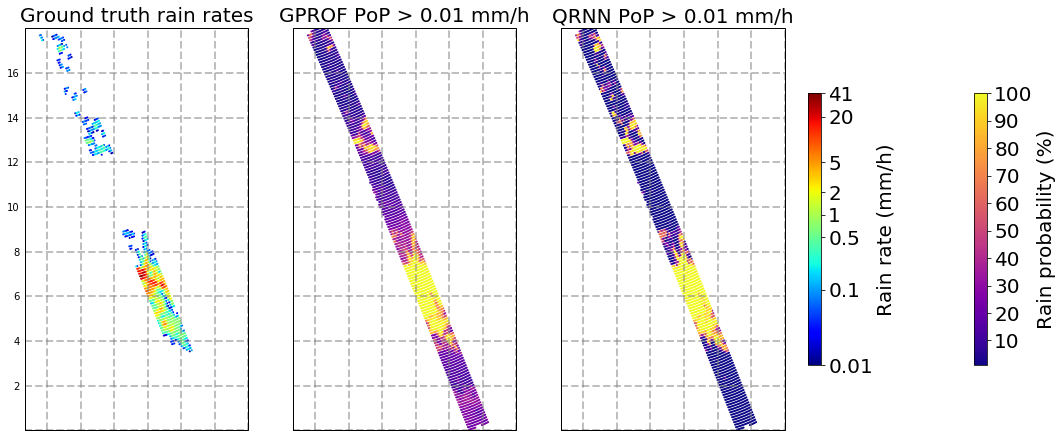

In [14]:
#threshold = 0.01
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection=proj),figsize = (20,20))
ax1 = axes.flatten()[0]
ax2 = axes.flatten()[1]
ax3 = axes.flatten()[2]


# PLOT GROUND TRUTH VALUES
min_val = 0.01
max_val = np.max(gt_data)
rain_ins = np.where(gt_data > threshold)
ax1.coastlines()
plt1 = ax1.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=gt_data[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax1.set_xlim([xmin,xmax])
ax1.set_ylim([ymin,ymax])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax1.set_title('Ground truth rain rates', fontsize = title_font)

cmap_pop = 'plasma'
# PLOT GPROF PoP
ax2.coastlines()
plt2 = ax2.scatter(lons,lats,marker='o',s=DPR_marker,c=PoP_gprof, cmap = cmap_pop)
ax2.set_xlim([xmin,xmax])
ax2.set_ylim([ymin,ymax])
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax2.set_title('GPROF PoP > ' + str(threshold) + ' mm/h', fontsize = title_font)

# PLOT QRNN PoP
ax3.coastlines()
plt3 = ax3.scatter(lons,lats,marker='o',s=DPR_marker,c=PoP_qrnn, cmap = cmap_pop)
ax3.set_xlim([xmin,xmax])
ax3.set_ylim([ymin,ymax])
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax3.set_title('QRNN PoP > ' + str(threshold) + ' mm/h', fontsize = title_font)

cbar = fig.colorbar(plt2, ax=axes.ravel().tolist(), shrink = 0.25, pad = 0.025,
                   ticks = [0,10,20,30,40,50,60,70,80,90,100])

cbar.set_label("Rain probability (%)", fontsize = 20)
cbar.ax.tick_params(labelsize=20)

cbar2 = fig.colorbar(plt1, ax=axes.ravel().tolist(), shrink = 0.25, pad = 0.025,
                   ticks = [0.01,0.1,0.5,1,2,5,20,int(max_val)])
cbar2.ax.set_yticklabels(['0.01','0.1' ,'0.5','1','2','5','20',str(int(max_val))])

cbar2.set_label("Rain rate (mm/h)", fontsize = 20)
cbar2.ax.tick_params(labelsize=20)

In [15]:
PoP_gprof = GPROF_PoP[a:b]
threshold_PoP = 5
PoP_qrnn = []
for i in range(a,b):
    PoP_qrnn.append(get_qrnn_PoP(qrnn_preds[i,:],threshold_PoP,quantiles))

In [16]:
# Alternative PoP
qrnn_PoP_sampled = []
for i in range(a,b):
    tmp_distr = qrnn_samples[i,:]
    qrnn_PoP_sampled.append(len(tmp_distr[tmp_distr > threshold_PoP])/len(tmp_distr))

print(len(qrnn_PoP_sampled))
print(len(PoP_qrnn))

3000
3000


In [17]:
print(a)
print(b)

24000
27000


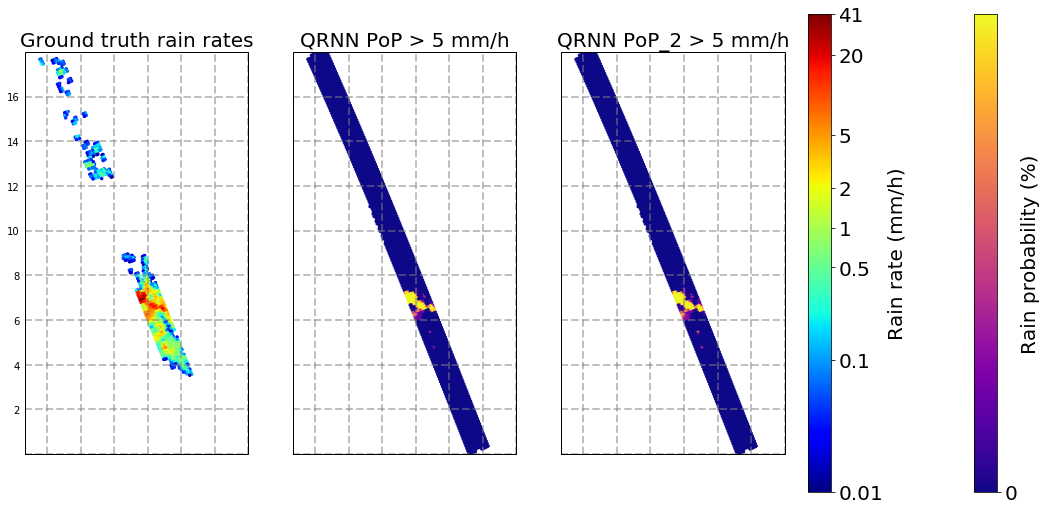

In [18]:
threshold = 0.01
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection=proj),figsize = (20,20))
ax1 = axes.flatten()[0]
ax2 = axes.flatten()[2]
ax3 = axes.flatten()[1]

marker_size = 6
# PLOT GROUND TRUTH VALUES
min_val = 0.01
max_val = np.max(gt_data)
rain_ins = np.where(gt_data > threshold)
ax1.coastlines()
plt1 = ax1.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=marker_size,c=gt_data[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax1.set_xlim([xmin,xmax])
ax1.set_ylim([ymin,ymax])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax1.set_title('Ground truth rain rates', fontsize = title_font)

cmap_pop = 'plasma'
# PLOT QRNN PoP 2
ax2.coastlines()
plt2 = ax2.scatter(lons,lats,marker='o',s=marker_size,c=qrnn_PoP_sampled, cmap = cmap_pop)
ax2.set_xlim([xmin,xmax])
ax2.set_ylim([ymin,ymax])
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax2.set_title('QRNN PoP_2 > ' + str(threshold_PoP) + ' mm/h', fontsize = title_font)

# PLOT QRNN PoP
ax3.coastlines()
plt3 = ax3.scatter(lons,lats,marker='o',s=marker_size,c=PoP_qrnn, cmap = cmap_pop)
ax3.set_xlim([xmin,xmax])
ax3.set_ylim([ymin,ymax])
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax3.set_title('QRNN PoP > ' + str(threshold_PoP) + ' mm/h', fontsize = title_font)

cbar = fig.colorbar(plt2, ax=axes.ravel().tolist(), shrink = 0.44, pad = 0.025,
                   ticks = [0,10,20,30,40,50,60,70,80,90,100])

cbar.set_label("Rain probability (%)", fontsize = 20)
cbar.ax.tick_params(labelsize=20)

cbar2 = fig.colorbar(plt1, ax=axes.ravel().tolist(), shrink = 0.44, pad = 0.025,
                   ticks = [0.01,0.1,0.5,1,2,5,20,int(max_val)])
cbar2.ax.set_yticklabels(['0.01','0.1' ,'0.5','1','2','5','20',str(int(max_val))])

cbar2.set_label("Rain rate (mm/h)", fontsize = 20)
cbar2.ax.tick_params(labelsize=20)

In [26]:
errors_median = qrnn_data_05 - gt_data
errors_mean   = qrnn_mean_tmp - gt_data
error_GPROF   = gprof_data - gt_data


min_val = -30
max_val = 30

n_bins = 2000

plt.figure(figsize=(15,8))
bins_all = np.linspace(min_val,max_val,n_bins)
n_GPROF,x_GPROF,_ = plt.hist(error_GPROF,bins=bins_all, normed=True);
n_3,x_3,_ = plt.hist(errors_median,bins=bins_all, normed=True);
n_2,x_2,_ = plt.hist(errors_mean,bins=bins_all, normed=True)

plt.clf()
bin_centers_2 = 0.5*(x_2[1:]+x_2[:-1])
bin_centers_3 = 0.5*(x_3[1:]+x_3[:-1])
bin_centers_GPROF = 0.5*(x_GPROF[1:]+x_GPROF[:-1])

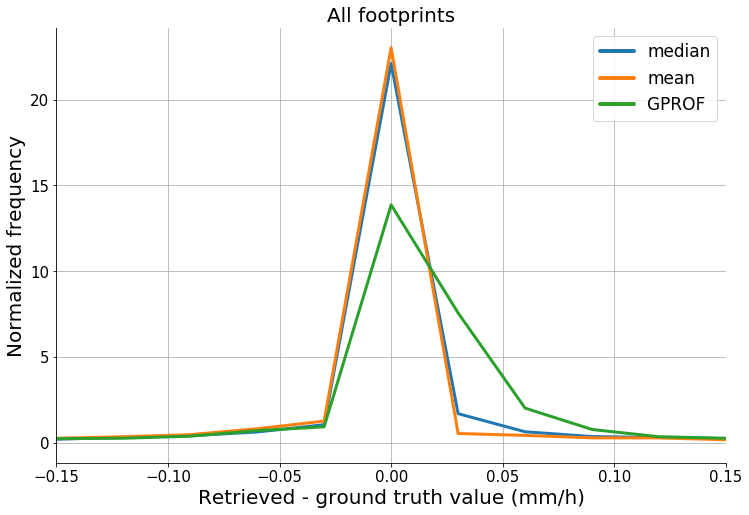

In [27]:
plt.figure(figsize=(12,8))
linew = 3
a = 500
plt.plot(bin_centers_2,n_2,label='median', lw = linew)
plt.plot(bin_centers_3,n_3,label='mean', lw = linew)
plt.plot(bin_centers_GPROF,n_GPROF,label='GPROF', lw = linew)
plt.xlim([-0.0003*a,0.0003*a])
label_font = 20
tick_s = 15
plt.ylabel('Normalized frequency', fontsize = label_font)
plt.xlabel('Retrieved - ground truth value (mm/h)', fontsize = label_font)
plt.title('All footprints', fontsize = label_font)
plt.xticks(fontsize=tick_s)
plt.yticks(fontsize=tick_s)
leg = plt.legend(prop={'size': 17})
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=4)
plt.grid()
plt.show()

In [28]:
mse_median = 0
mse_mean = 0
mse_GPROF = 0
for i in range(0,len(errors_mean)):
    mse_GPROF = mse_GPROF + error_GPROF[i]**2
    mse_mean = mse_mean + errors_mean[i]**2
    mse_median = mse_median + errors_median[i]**2
    
print('---- MSE ----')
print('Mean:    ' + str(mse_mean/len(errors_mean)))
print('Median:  ' + str(mse_median/len(errors_median)))
print('GPROF:   ' + str(mse_GPROF/len(error_GPROF)))

---- MSE ----
Mean:    1.0840012275187025
Median:  0.9259140532573865
GPROF:   1.144772773384282


In [19]:
hi_rain_inds = np.where(gt_data > 30)
for A in range(0,len(hi_rain_inds[0])):
    print('---------------------------------------')
    i = hi_rain_inds[0][A]
    print('GT label:       ' + str(gt_data[i]))
    print('QRNN median:    ' + str(qrnn_data_05[i]))
    print('QRNN mean:      ' + str(qrnn_mean_tmp[i]))
    print('QRNN 0.1:       ' + str(qrnn_data_01[i]))
    print('QRNN 0.9:       ' + str(qrnn_data_09[i]))
    print('GPROF:          ' + str(gprof_data[i]))


---------------------------------------
GT label:       30.417020797729492
QRNN median:    25.168583
QRNN mean:      27.08138387747788
QRNN 0.1:       15.7234535
QRNN 0.9:       38.20419
GPROF:          25.06281280517578
---------------------------------------
GT label:       41.04951477050781
QRNN median:    36.46123
QRNN mean:      35.39801259296275
QRNN 0.1:       23.49075
QRNN 0.9:       51.583694
GPROF:          26.167884826660156
---------------------------------------
GT label:       38.09109115600586
QRNN median:    28.627005
QRNN mean:      28.601418313083514
QRNN 0.1:       18.02445
QRNN 0.9:       41.753075
GPROF:          19.10746192932129


(3000, 15)
(3000,)
[[ 7.6975803 11.5263195 13.526443  15.754641  16.898733  18.428223
  21.243961  22.032518  24.4465    28.231192  38.190823 ]]
Ground truth value:   17.805866241455078
Median value:         18.42822
Expectation value:    1.0724207760594298
Sampled mean:         17.86032521786242
Sampled var:          0.0028667693345674717


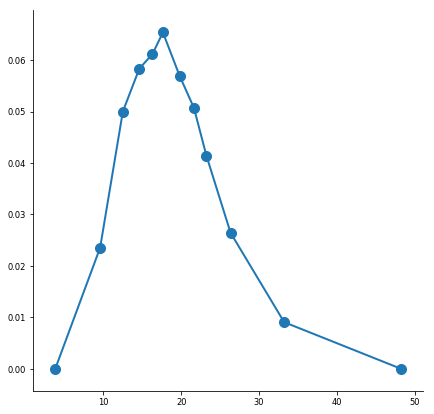

In [56]:
hi_rain_inds = np.where(gt_data > 10)
x_test_tmp = x_test[a:b,:]

print(x_test_tmp.shape)
print(gt_data.shape)
A = 3
i = hi_rain_inds[0][A]
xs, fs  = qrnn.pdf(x_test_tmp[i])
qs = qrnn.predict(x_test_tmp[i])
print(qs)
fs[fs < 0 ] = 0

exp_val = np.trapz(fs, x=xs)
print('Ground truth value:   ' + str(gt_data[i]))
print('Median value:         ' + str(qrnn_data_05[i]))
print('Expectation value:    ' + str(exp_val))
print('Sampled mean:         ' + str(qrnn_mean_tmp[i]))
print('Sampled var:          ' + str(qrnn_mean_var[i]/np.sqrt(1000)))


plt.figure(figsize=(7,7))
plt.plot(xs,fs,linestyle = '-')
plt.scatter(xs,fs)
plt.show()

In [57]:
qs  = qrnn.predict(x_test_tmp[i])
xs, fs = qrnn.cdf(x_test_tmp[i])

exp_val = xs[-1]*1.0 - xs[0]*0.0 - np.trapz(fs[:],x=xs[:])
print(exp_val)

19.405868887901306


In [55]:
np.trapz?

In [49]:
qs

array([[ 4.6356635,  7.0726423,  8.402262 ,  9.876403 , 10.624364 ,
        11.639253 , 13.4171505, 13.855848 , 15.386919 , 17.693958 ,
        24.024797 ]], dtype=float32)

array([ 2.19868469,  5.85415268,  7.73745203,  9.13933182, 10.25038338,
       11.13180828, 12.52820206, 13.6364994 , 14.62138367, 16.54043961,
       20.85937881, 30.3556366 ])